Comment prédire le podium d'une course de Formule Un ? 

Librairies : 

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score


Chargement des données : 

In [2]:
drivers = pd.read_csv(os.path.join("donnees_formule_un", "drivers.csv")\
    , on_bad_lines='skip')
drivers.columns = drivers.columns.str.strip()
drivers["forename"] = drivers["forename"].str.replace('"', '').str.strip()
drivers["surname"] = drivers["surname"].str.replace('"', '').str.strip()
drivers["nom_complet"] = drivers["forename"] + " " + drivers["surname"]

constructors = pd.read_csv(os.path.join("donnees_formule_un", "constructors.csv"))
constructors.columns = constructors.columns.str.strip()

results = pd.read_csv(os.path.join("donnees_formule_un", "results.csv"))
results.columns = results.columns.str.strip()

races = pd.read_csv(os.path.join("donnees_formule_un", "races.csv"))
races.columns = races.columns.str.strip()
constructor_standings = pd.read_csv(os.path.join("donnees_formule_un", "constructor_standings.csv"))
constructor_standings.columns = constructor_standings.columns.str.strip()





Table énorme 

In [ ]:
table_1 = pd.merge(races, results, on= "raceId")
table_2 = pd.merge(table_1, constructors, on = "constructorId")
table = pd.merge(table_2, drivers, on = "driverId")



#sélectionner les variables dans la table
table = table[['raceId', 'year', 'name_x', 'nom_complet', 'name_y', 'positionOrder', 'grid']]

# table triée sur les années 2021, 2022, 2023 et 2024 :
df = table[(table['year'] == 2023) | (table['year'] == 2024)| (table['year'] == 2022)| (table['year'] == 2021)]
df = df.drop_duplicates(subset=['raceId', 'nom_complet']) # éviter les doublons



Info :
name_x = nom du circuit 
name_y = nom de constructeur 

Variables utilisées pour la régression logistique 

In [17]:
fusion = pd.merge(constructor_standings, races, on='raceId')
fusion = fusion[['raceId', 'constructorId', 'points', 'position', 'year', 'date']]
fusion_now = pd.merge(fusion, constructors, on='constructorId')


# Assure-toi que la colonne 'date' est bien de type datetime
fusion_now['date'] = fusion_now['date'].str.strip().str.replace('"', '')
fusion_now['date'] = pd.to_datetime(fusion_now['date'], format="%Y-%m-%d", errors='coerce')

fusion_2 = fusion_now[['raceId', 'position', 'name' , 'date']]
fusion_2 = fusion_2.rename(columns={'name': 'name_y'})
# On suppose que chaque ligne correspond à un pilote ou une écurie pour une course
# Tu dois avoir une colonne 'raceId', 'constructorId' (ou 'name_y') et 'position'

# Trier les données par écurie et date de course
fusion_2 = fusion_2.sort_values(by=['date'])

# Décaler la position par groupe d’écurie
fusion_2['position_prec'] = fusion_2.groupby('name_y')['position'].shift(1)
fusion_2.rename(columns={'position_prec': 'position_y'}, inplace=True)


fusion_2 = fusion_2[['raceId', 'position_y', 'name_y']]


if 'position_y' in df.columns:
    df = df.drop(columns=['position_y'])
    
df = pd.merge(df, fusion_2, on=['raceId', 'name_y'], how='left')




In [22]:
# Nombre de victoires par pilote
nb_victoire_3_ans = df[df["positionOrder"] == 1].groupby("nom_complet").size()
# Ajouter un nom à la Série pour pouvoir la fusionner
nb_victoire_3_ans.name = 'nb_victoire_3_ans'
# Fusionner avec le DataFrame df
if 'nb_victoire_3_ans' in df.columns:
    df = df.drop(columns=['nb_victoire_3_ans'])

df = df.merge(nb_victoire_3_ans, on = "nom_complet", how = "left")
df["nb_victoire_3_ans"] = df["nb_victoire_3_ans"].fillna(0)


# Nombre de podium par pilote
nb_podium_3_ans = df[(df["positionOrder"] == 1) | (df["positionOrder"] == 2)\
    | (df["positionOrder"] == 3)].groupby("nom_complet").size()
# Ajouter un nom à la Série pour pouvoir la fusionner
nb_podium_3_ans.name = 'nb_podium_3_ans'
if 'nb_podium_3_ans' in df.columns:
    df = df.drop(columns=['nb_podium_3_ans'])
# Fusionner avec le DataFrame df
df = df.merge(nb_podium_3_ans, on = "nom_complet", how = "left")
# Remplir les NaN avec 0
df["nb_podium_3_ans"] = df["nb_podium_3_ans"].fillna(0)


# Position au départ de la course
# correspond à la variable grid de df


# Ecurie actuelle du pilote
df['name_y'] = df['name_y'].str.strip('" ') #pour avoir un nom prore
# Supprimer les anciennes colonnes d'ecurie si elles existent déjà
df = df.loc[:, ~df.columns.str.startswith('ecurie_')]
# Ecurie actuelle du pilote
df['ecurie'] = df['name_y'].str.strip()    # très important de STRIP ici aussi !!
# One-Hot Encoding
ecuries_encoded = pd.get_dummies(df['ecurie'], prefix='ecurie')
# Ajouter les colonnes au DataFrame
df = pd.concat([df, ecuries_encoded], axis=1)


# Convertir tout booléen en int (True → 1, False → 0)
df = df.astype({col: int for col in df.select_dtypes(include='bool').columns})

# Position actuelle dans le championnat
# correspond à  la variable position de la table driver standings

# Création de colonnes d'interaction si elles n'existent pas déjà
if 'grid_x_nb_podium' not in df.columns:
    df['grid_x_nb_podium'] = df['grid'] * df['nb_podium_3_ans']

if 'grid_x_nb_victoire' not in df.columns:
    df['grid_x_nb_victoire'] = df['grid'] * df['nb_victoire_3_ans']

# Victoires par écurie sur 3 ans
if 'nb_victoire_ecurie_3_ans' not in df.columns:
    victoires_par_ecurie = (
        df.groupby(['raceId', 'ecurie'])['nb_victoire_3_ans']
        .sum()
        .reset_index()
        .rename(columns={'nb_victoire_3_ans': 'nb_victoire_ecurie_3_ans'})
    )
    df = df.merge(victoires_par_ecurie, on=['raceId', 'ecurie'], how='left')

# Podiums par écurie sur 3 ans
if 'nb_podium_ecurie_3_ans' not in df.columns:
    podiums_par_ecurie = (
        df.groupby(['raceId', 'ecurie'])['nb_podium_3_ans']
        .sum()
        .reset_index()
        .rename(columns={'nb_podium_3_ans': 'nb_podium_ecurie_3_ans'})
    )
    df = df.merge(podiums_par_ecurie, on=['raceId', 'ecurie'], how='left')

# Interaction podium écurie x dummies écurie
for col in df.columns:
    if col.startswith("ecurie_"):
        col_name = col.replace("ecurie_", "")
        new_col = f"nb_podium_x_{col_name}"
        if new_col not in df.columns:
            df[new_col] = df["nb_podium_ecurie_3_ans"] * df[col]

# Interaction victoire écurie x dummies écurie
for col in df.columns:
    if col.startswith("ecurie_"):
        col_name = col.replace("ecurie_", "")
        new_col = f"nb_victoire_x_{col_name}"
        if new_col not in df.columns:
            df[new_col] = df["nb_victoire_ecurie_3_ans"] * df[col]

# Interaction position_y x podium/victoire 3 ans
if "position_y_x_nb_podium_3_ans" not in df.columns:
    df["position_y_x_nb_podium_3_ans"] = df["position_y"] * df["nb_podium_3_ans"]

if "position_y_x_nb_victoire_3_ans" not in df.columns:
    df["position_y_x_nb_victoire_3_ans"] = df["position_y"] * df["nb_victoire_3_ans"]

# Inverse de position_y et interaction avec les écuries
if "position_y_inverse" not in df.columns:
    df["position_y_inverse"] = 1 / (df["position_y"])

ecuries = [col for col in df.columns if col.startswith("ecurie_")]
for ecurie in ecuries:
    nom_colonne = f"{ecurie}_x_pos_inv"
    if nom_colonne not in df.columns:
        df[nom_colonne] = df[ecurie] * df["position_y_inverse"]

# Nettoyage éventuel des noms de colonnes
df.columns = df.columns.str.strip()



Régression logistique 

Accuracy du modèle pour la prédiction du podium : 0.92


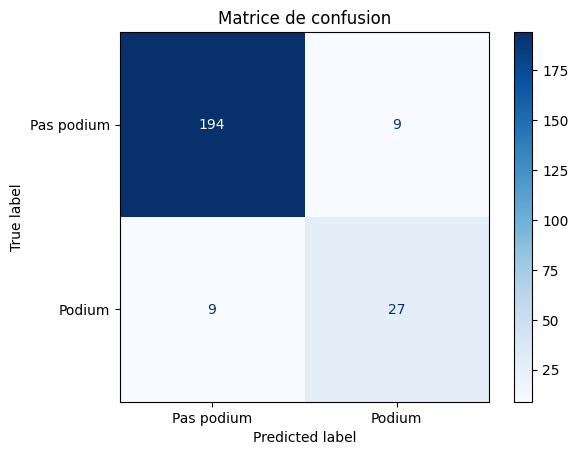

Rapport de classification :
              precision    recall  f1-score   support

  Pas podium       0.96      0.96      0.96       203
      Podium       0.75      0.75      0.75        36

    accuracy                           0.92       239
   macro avg       0.85      0.85      0.85       239
weighted avg       0.92      0.92      0.92       239

                            feature  coefficient
20     nb_victoire_x_Alpine F1 Team     1.034762
37            ecurie_Alpine F1 Team     1.034762
38              ecurie_Aston Martin     0.706145
32               position_y_inverse     0.492217
56        ecurie_Red Bull_x_pos_inv     0.343405
51         ecurie_Ferrari_x_pos_inv     0.302248
13             nb_podium_x_Mercedes     0.262193
15             nb_podium_x_Red Bull     0.155657
53         ecurie_McLaren_x_pos_inv     0.142887
17             nb_podium_x_Williams     0.133937
27           nb_victoire_x_Red Bull     0.092732
42                  ecurie_Mercedes     0.080031
12      

In [ ]:

# === CONFIG ===

OUTPUT_DIR = "sorties_modele"


os.makedirs(OUTPUT_DIR, exist_ok=True)




# 1. Variable cible : sur le podium ou non
df["sur_podium"] = df["positionOrder"].isin([1, 2, 3]).astype(int)



# 2. Choix des colonnes à exclures car résultat ou de variables catégorielles
colonnes_a_exclure = ['raceId', 'year', 'name_x', 'name_y', 'nom_complet', 'ecurie', 'sur_podium', 'positionOrder']
# 3. Séparer les jeux d'entraînement et de test
df_train = df[(df['year'] == 2021)|(df['year'] == 2022)|(df['year'] == 2023)].copy()
df_test = df[(df['year'] == 2024)].copy()

# 4. Créer X et y
X_train = df_train.drop(columns=colonnes_a_exclure).fillna(0)
y_train = df_train['sur_podium']

X_test = df_test.drop(columns=colonnes_a_exclure).fillna(0)
y_test = df_test['sur_podium']

# Aligner les colonnes
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# 5. Entraîner le modèle
model = LogisticRegression(max_iter=5000, class_weight="balanced")
model.fit(X_train, y_train)


# 6. Prédictions avec ajustement du seuil
y_prob = model.predict_proba(X_test)[:, 1]
y_pred = (y_prob > 0.78).astype(int)




# === EVALUATION ===

report = classification_report(y_test, y_pred, target_names=["Pas podium", "Podium"])

# Sauvegarder le rapport texte
with open(os.path.join(OUTPUT_DIR, "classification_report.txt"), "w") as f:
    f.write(report)

# Sauvegarder la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pas podium", "Podium"], yticklabels=["Pas podium", "Podium"])
plt.title("Matrice de confusion")
plt.savefig(os.path.join(OUTPUT_DIR, "confusion_matrix.png"))
plt.close()

# Sauvegarder les coefficients du modèle
coeff_df = pd.DataFrame({
    "feature": X_train.columns,
    "coefficient": model.coef_[0]
}).sort_values(by="coefficient", ascending=False)
coeff_df.to_csv(os.path.join(OUTPUT_DIR, "coefficients.csv"), index=False)

# Sauvegarder les prédictions
predictions_df = X_test.copy()
predictions_df["true_label"] = y_test
predictions_df["predicted_label"] = y_pred
predictions_df.to_csv(os.path.join(OUTPUT_DIR, "predictions.csv"), index=False)


#afficher dans le Jupiter Notebook
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy du modèle pour la prédiction du podium : {accuracy:.2f}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Pas podium", "Podium"])
disp.plot(cmap="Blues")
plt.title("Matrice de confusion")
plt.show()

print("Rapport de classification :")
print(classification_report(y_test, y_pred, target_names=["Pas podium", "Podium"]))

print(coeff_df)